In [1]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

sp.__version__

'1.10.1'

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_interp_spline.html#scipy.interpolate.make_interp_spline

#### Алгоритмы планирования траекторий

1. Генерация $\mathcal{C}^0$ гладкой траектории через 10 точек. 
2. Генерация $\mathcal{C}^1$ гладкой траектории
3. Генерация $\mathcal{C}^2$ гладкой траектории

In [133]:
# Координаты точек:
x = [15,5,7,9,18,13,2,-2,1,3]
y = [ 6,4,15,8,11,17,23,19,1,13]
coordinates = {'x':np.array(x), 'y':np.array(y)}

In [137]:
phi=[[]]
phi[0] = np.arctan2(np.array(coordinates['y'][0:4])-6.5, np.array(coordinates['x'][0:4])-7.5)
for i in range(len(phi[0])):
    if phi[0][i] > 0:
        phi[0][i] -= np.pi*2
phi

[array([-0.06656816, -2.35619449, -4.65363316, -5.49778714])]

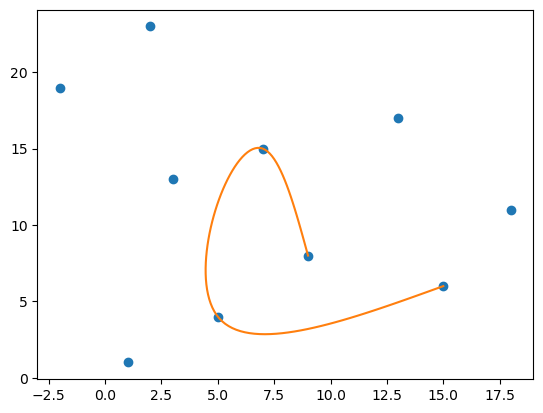

In [151]:
# С1 trajectory
# sp.interpolate.Akima1DInterpolator(coordinates['x'],coordinates['y'])
# poly1 = sp.interpolate.lagrange(coordinates['x'],coordinates['y'])
# scipy.interpolate.CloughTocher2DInterpolator([coordinates['x'],coordinates['y']],)

points_num = 4
phi=[[]]
phi[0] = np.arctan2(coordinates['y'][0:points_num]-7.5, coordinates['x'][0:points_num]-8)
for i in range(len(phi[0])):
    if phi[0][i] > 0:
        phi[0][i] -= np.pi*2
phi[0]*=-1
# phi[0][2] = 3
spl = sp.interpolate.make_interp_spline(  phi[0],np.c_[coordinates['x'][0:points_num],coordinates['y'][0:points_num]],bc_type='natural')

# t=[-1,0,1]
# k=3
# t = np.r_[(coordinates['x'][0],)*(k+1),
#           t,
#           (coordinates['x'][-1],)*(k+1)]
# spl  = sp.interpolate.make_lsq_spline(coordinates['x'],coordinates['y'],t,k)
# plt.plot(coordinates['x'],coordinates['y'])
# plt.plot(coordinates['x'],spl(coordinates['x']))

phi_new = np.linspace(phi[0][0],phi[0][-1] , 100)
x_new, y_new = spl(phi_new).T
plt.plot(coordinates['x'],coordinates['y'], 'o')
plt.plot(x_new, y_new, '-')

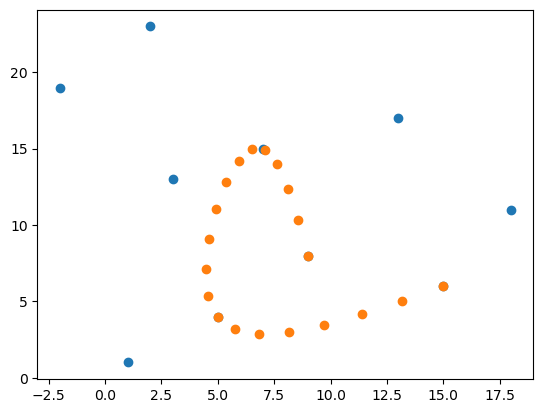

In [153]:
phi_new = np.linspace(phi[0][0],phi[0][-1] , 20)
x_new, y_new = spl(phi_new).T
plt.plot(coordinates['x'],coordinates['y'], 'o')
plt.plot(x_new, y_new, 'o')

In [ ]:
new_c

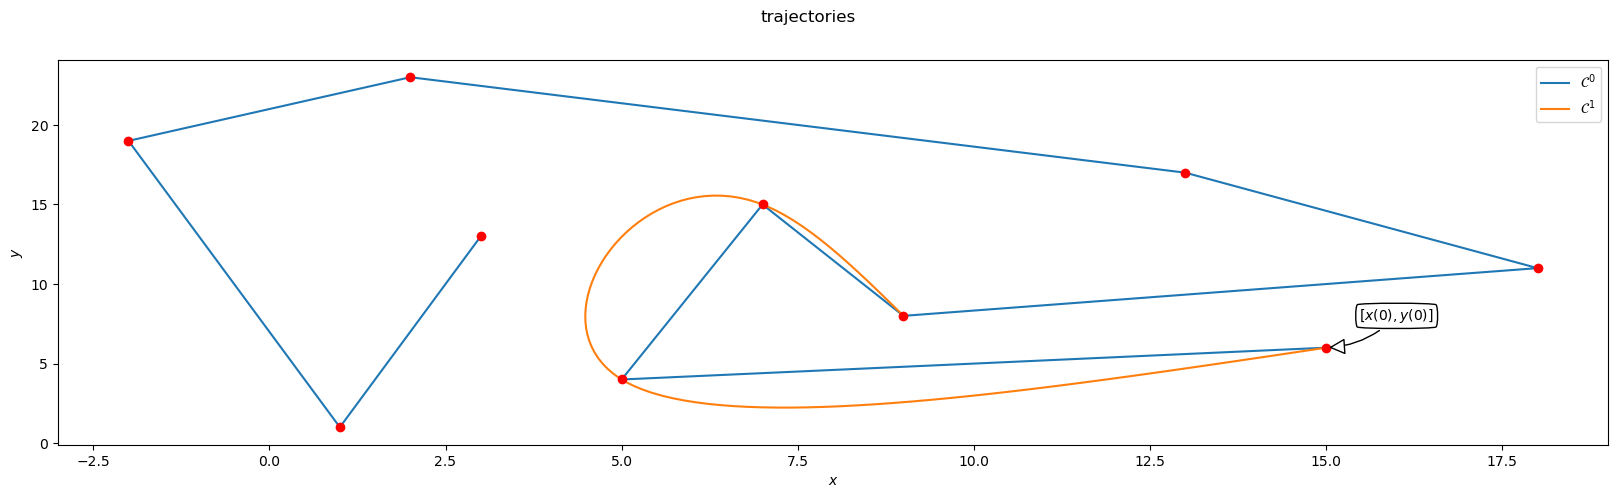

In [132]:
fig, ax = plt.subplots(1,1,figsize = (20,5))
ax = [ax, 1]
C0, = ax[0].plot(coordinates['x'],coordinates['y'])
C1, = ax[0].plot(x_new, y_new)


for i in range(len(coordinates['x'])):
    ax[0].plot(coordinates['x'][i],coordinates['y'][i],'or')

ax[0].annotate(rf'$[x(0),y(0)]$',
                  xy=(coordinates['x'][0],coordinates['y'][0]),
                  xytext=(coordinates['x'][0]+1,coordinates['y'][0]+2),
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",mutation_scale=25,
                                  connectionstyle="arc3,rad=-0.2", fc="w"))
fig.suptitle("trajectories")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].legend([C0,C1], ['$\mathcal{C}^0$','$\mathcal{C}^1$'])